# **Tendencias Salariales en Empleos de Ciencia de Datos, AI y ML (2025)**

**Autores:** Laura Cardona Ahumada, Elian Martinez Orozco, Evelyn Mondul y Luis Pino Perez

**Fecha:** agosto 2025

---

### **Introducción**

Esta base de datos presenta información actualizada sobre salarios globales en 2025 para profesionales de Ciencia de Datos, Aprendizaje Automático e Inteligencia Artificial. Fue construida a partir de fuentes públicas como AIJobs, 365DataScience, Payscale, KDnuggets y ZipRecruiter, y está orientada a apoyar análisis de mercado, modelos predictivos, visualizaciones interactivas y estudios sobre trabajo remoto.

El conjunto de datos fue obtenido desde Kaggle, a partir del recurso publicado por el usuario adilshamim8 bajo el título "Salaries for Data Science Jobs": https://www.kaggle.com/datasets/adilshamim8/salaries-for-data-science-jobs?resource=download. Su contenido resulta útil para investigadores, profesionales del sector, estudiantes y reclutadores que buscan entender las dinámicas actuales de compensación en el ámbito tecnológico.

---

### **Objetivo**

El presente análisis tiene como objetivo desarrollar un modelo de aprendizaje automático capaz de predecir el rango salarial de empleos relacionados con Ciencia de Datos, Inteligencia Artificial y Aprendizaje Automático, a partir de información sobre características laborales y profesionales.  
Además, se realizará un análisis exploratorio detallado de los datos para identificar patrones, desigualdades y factores determinantes del salario en estas áreas tecnológicas emergentes.

---

En este notebook se encuentran las siguientes sesiones: 
1. Importaciones y configuración inicial
2. Carga de datos y selección de columnas
3. Análisis exploratorio de datos - EDA
4. Split Train / Validation / Test
5. Preprocesamiento
6. Modelos y búsqueda de hiperparámetros
7. Funciones auxiliares
8. Loop para evaluar modelos + gráficas + BDS
9. DataFrame de resultados y gráfico comparativo


## 1. Importaciones y configuración inicial
Aquí cargamos todas las librerías necesarias:
1. Sklearn → para modelos, pipelines, métricas y validación cruzada.
2. XGBoost y MLP → modelos más avanzados.
3. statsmodels.tsa.stattools → para el BDS test en los residuos.
4. Matplotlib / PrettyTable → para gráficos y tablas estructuradas.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
from scipy.stats import randint, uniform
from statsmodels.tsa.stattools import bds
from prettytable import PrettyTable

## 2. Carga de datos y selección de columnas

1. Leemos el archivo salaries.csv.
2. Definimos variables categóricas (ejemplo: job_title, company_size) y numéricas (ejemplo: salario, work_year).
3. Construimos X_full (features) y y_full_price (target → salary_in_usd).

Aquí limpiamos y organizamos el dataset.

In [2]:
DATA_PATH = r"C:\Users\LUIS PINO\Documents\Machine_learning\Proyecto_final\salaries.csv"
df = pd.read_csv(DATA_PATH)

categorical_features = ['experience_level','employment_type','job_title','salary_currency','employee_residence','company_location','company_size']
numeric_features = ['work_year','salary','salary_in_usd','remote_ratio']

categorical_features = [c for c in categorical_features if c in df.columns]
numeric_features = [c for c in numeric_features if c in df.columns]

X_full = df[categorical_features + numeric_features].copy()
y_full_price = df['salary_in_usd'].copy()

## 3. Análisis exploratorio de datos - EDA

In [3]:
sns.set(style='whitegrid', palette='Set2')
plt.rcParams['figure.figsize'] = (10, 6)

# Mostrar las primeras filas
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,EX,FT,Head of Data,348516,USD,348516,US,0,US,M
1,2025,EX,FT,Head of Data,232344,USD,232344,US,0,US,M
2,2025,SE,FT,Data Scientist,145400,USD,145400,US,0,US,M
3,2025,SE,FT,Data Scientist,81600,USD,81600,US,0,US,M
4,2025,MI,FT,Engineer,160000,USD,160000,US,100,US,M


#### **Dataset**

In [4]:
# Dimensiones
print(f"Filas: {df.shape[0]}, Columnas: {df.shape[1]}")

# Tipos de datos
print(df.dtypes)

# Información general
print(df.info())

# Estadísticas descriptivas
print(df.describe(include='all'))

# duplicadas
print("\nFilas duplicadas:", df.duplicated().sum())

Filas: 151445, Columnas: 11
work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151445 entries, 0 to 151444
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   work_year           151445 non-null  int64 
 1   experience_level    151445 non-null  object
 2   employment_type     151445 non-null  object
 3   job_title           151445 non-null  object
 4   salary              151445 non-null  int64 
 5   salary_currency     151445 non-null  object
 6   salary_in_usd       151445 non-null  int64 
 7   employee_residence  151445 non-null  object
 8   remote_ratio        151445 non-nu

            work_year experience_level employment_type       job_title  \
count   151445.000000           151445          151445          151445   
unique            NaN                4               4             422   
top               NaN               SE              FT  Data Scientist   
freq              NaN            87491          150541           18751   
mean      2024.435313              NaN             NaN             NaN   
std          0.671842              NaN             NaN             NaN   
min       2020.000000              NaN             NaN             NaN   
25%       2024.000000              NaN             NaN             NaN   
50%       2025.000000              NaN             NaN             NaN   
75%       2025.000000              NaN             NaN             NaN   
max       2025.000000              NaN             NaN             NaN   

              salary salary_currency  salary_in_usd employee_residence  \
count   1.514450e+05          151445 

### **Variables**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151445 entries, 0 to 151444
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   work_year           151445 non-null  int64 
 1   experience_level    151445 non-null  object
 2   employment_type     151445 non-null  object
 3   job_title           151445 non-null  object
 4   salary              151445 non-null  int64 
 5   salary_currency     151445 non-null  object
 6   salary_in_usd       151445 non-null  int64 
 7   employee_residence  151445 non-null  object
 8   remote_ratio        151445 non-null  int64 
 9   company_location    151445 non-null  object
 10  company_size        151445 non-null  object
dtypes: int64(4), object(7)
memory usage: 12.7+ MB


In [6]:
df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,151445.000000,1.514450e+05,151445.000000,151445.000000
mean,2024.435313,1.628380e+05,157527.458411,20.938625
std,0.671842,2.080124e+05,74150.772377,40.620393
min,2020.000000,1.400000e+04,15000.000000,0.000000
25%,2024.000000,1.060000e+05,105800.000000,0.000000
50%,2025.000000,1.470000e+05,146100.000000,0.000000
75%,2025.000000,1.990000e+05,198000.000000,0.000000
max,2025.000000,3.040000e+07,800000.000000,100.000000


 El 93% de los datos corresponden a 2024–2025. Los salarios típicos en USD se ubican entre 105,000 y 198,000, aunque existen outliers muy altos (hasta 800,000). La mitad de los empleos son presenciales, con una proporción menor en teletrabajo total.

#### Distribución de variables numéricas

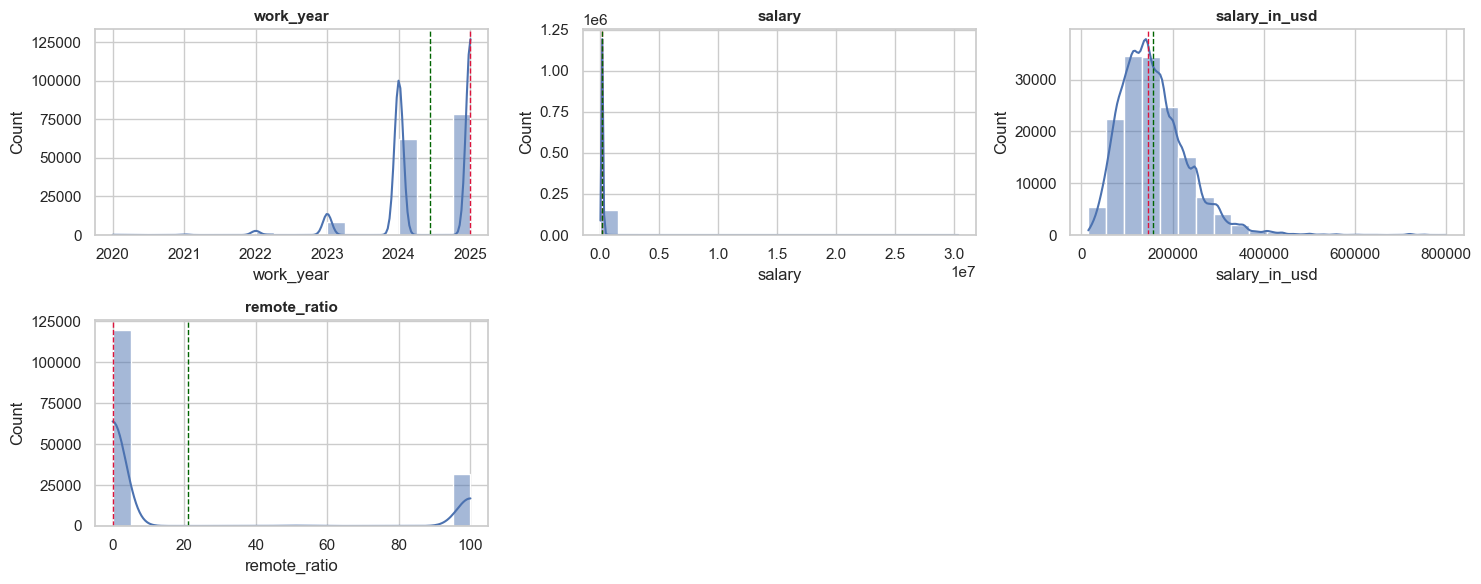

In [7]:
sns.set(style="whitegrid")

numerical_cols = df.select_dtypes(include=np.number).columns
n = len(numerical_cols)

# Calcular filas y columnas automáticamente
cols = 3
rows = (n // cols) + (n % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=True, bins=20, color='#4C72B0', ax=axes[i])
    axes[i].axvline(df[col].median(), color='crimson', linestyle='--', linewidth=1)
    axes[i].axvline(df[col].mean(), color='darkgreen', linestyle='--', linewidth=1)
    axes[i].set_title(f"{col}", fontsize=11, fontweight="bold")

# Eliminar ejes vacíos
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Distribución de variables categóricas

C:\Users\LUIS PINO\AppData\Local\Temp\ipykernel_13920\2877972932.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
C:\Users\LUIS PINO\AppData\Local\Temp\ipykernel_13920\2877972932.py:12: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax = sns.countplot(


C:\Users\LUIS PINO\AppData\Local\Temp\ipykernel_13920\2877972932.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
C:\Users\LUIS PINO\AppData\Local\Temp\ipykernel_13920\2877972932.py:12: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax = sns.countplot(


C:\Users\LUIS PINO\AppData\Local\Temp\ipykernel_13920\2877972932.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
C:\Users\LUIS PINO\AppData\Local\Temp\ipykernel_13920\2877972932.py:12: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  ax = sns.countplot(


C:\Users\LUIS PINO\AppData\Local\Temp\ipykernel_13920\2877972932.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
C:\Users\LUIS PINO\AppData\Local\Temp\ipykernel_13920\2877972932.py:12: UserWarning: 
The palette list has fewer values (8) than needed (15) and will cycle, which may produce an uninterpretable plot.
  ax = sns.countplot(


C:\Users\LUIS PINO\AppData\Local\Temp\ipykernel_13920\2877972932.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
C:\Users\LUIS PINO\AppData\Local\Temp\ipykernel_13920\2877972932.py:12: UserWarning: 
The palette list has fewer values (8) than needed (15) and will cycle, which may produce an uninterpretable plot.
  ax = sns.countplot(


C:\Users\LUIS PINO\AppData\Local\Temp\ipykernel_13920\2877972932.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
C:\Users\LUIS PINO\AppData\Local\Temp\ipykernel_13920\2877972932.py:12: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  ax = sns.countplot(


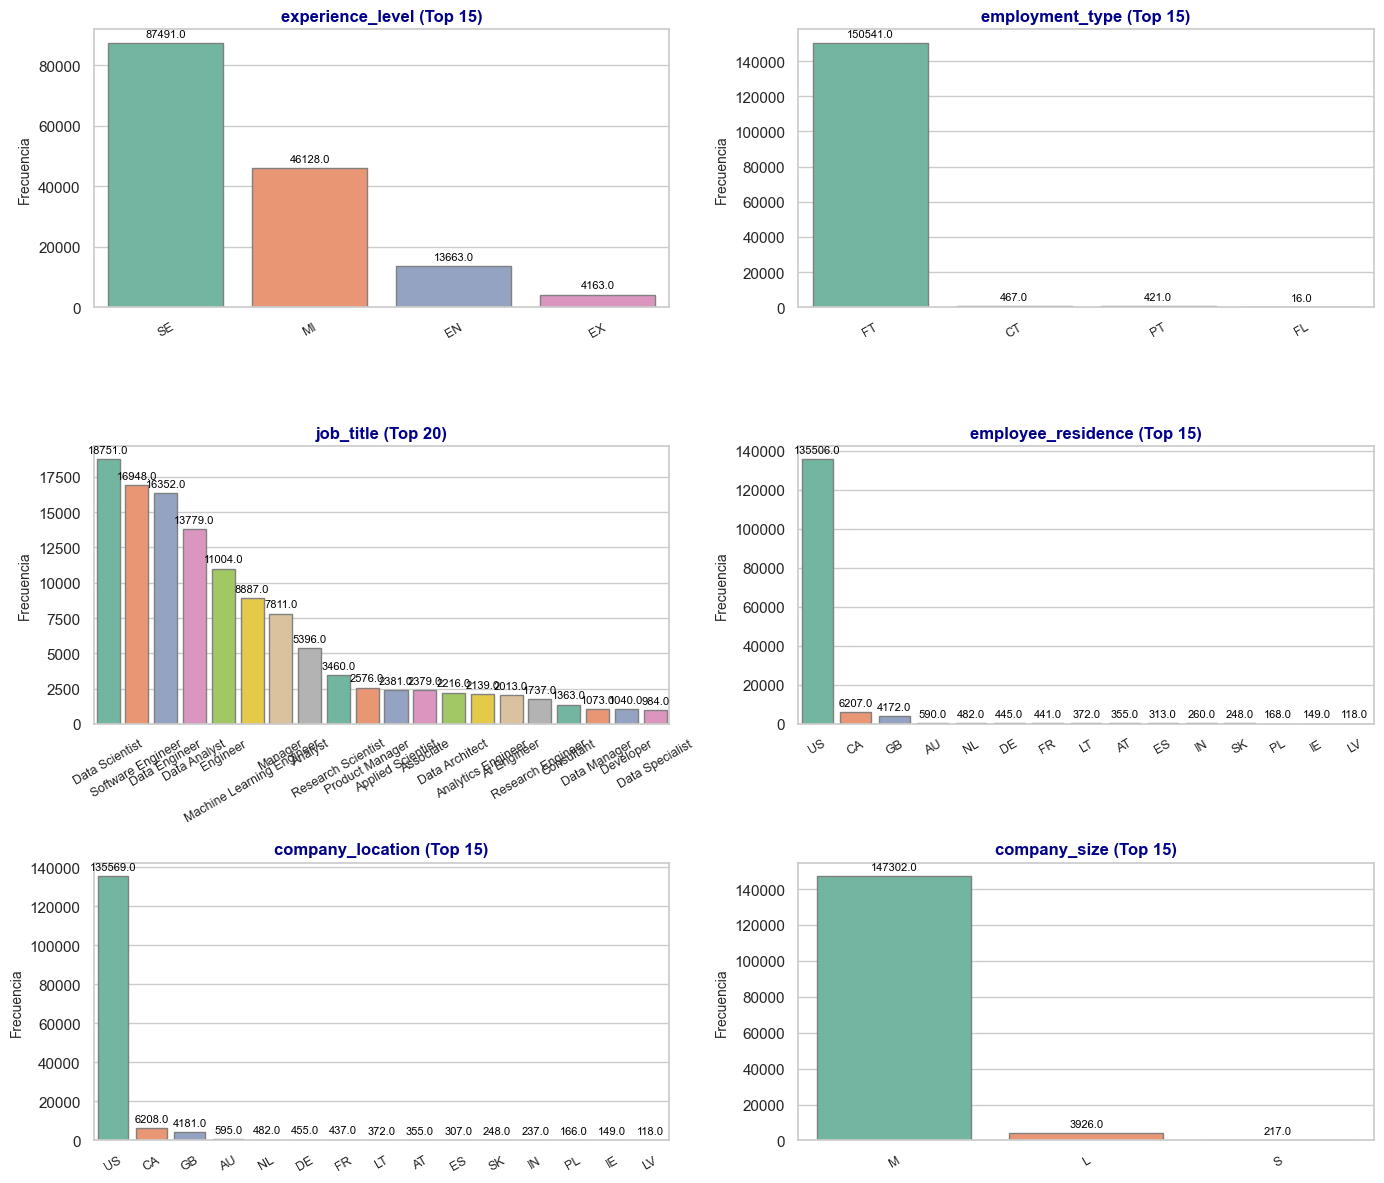

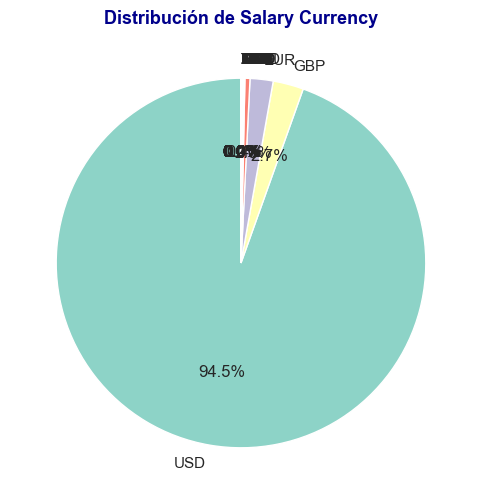

In [8]:
sns.set_style("whitegrid")
palette_cat = sns.color_palette("Set2")

# Función auxiliar: Top N
def plot_top_categories(df, col, top_n=15, ax=None):
    """
    Grafica un countplot con las Top N categorías más frecuentes.
    """
    top_values = df[col].value_counts().nlargest(top_n).index
    data = df[df[col].isin(top_values)]

    ax = sns.countplot(
        data=data,
        x=col,
        order=data[col].value_counts().index,
        palette=palette_cat,
        edgecolor='gray',
        ax=ax
    )

    ax.set_title(f'{col} (Top {top_n})', fontsize=12, fontweight='bold', color='darkblue')
    ax.set_xlabel("")
    ax.set_ylabel("Frecuencia", fontsize=10)
    ax.tick_params(axis='x', rotation=30, labelsize=9)

    # Etiquetas en las barras
    for bar in ax.patches:
        height = bar.get_height()
        if height > 0:
            ax.annotate(f'{height}', 
                        (bar.get_x() + bar.get_width()/2, height),
                        ha='center', va='bottom', fontsize=8,
                        color='black', xytext=(0, 3),
                        textcoords='offset points')

    return ax


# Gráficas categóricas
categorical_cols = df.select_dtypes(include='object').columns

# Ajustes para columnas específicas
special_top = {
    "job_title": 20,            
    "employee_residence": 15,   
    "company_location": 15      
}

# Excluir salary_currency (lo graficamos como pastel)
categorical_cols = [c for c in categorical_cols if c != "salary_currency"]

n = len(categorical_cols)
cols = 2
rows = (n // cols) + (n % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 4))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    top_n = special_top.get(col, 15)  # por defecto Top 15
    plot_top_categories(df, col, top_n=top_n, ax=axes[i])

# Eliminar ejes sobrantes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# Gráfico de Salary Currency

currency_counts = df["salary_currency"].value_counts()

plt.figure(figsize=(6,6))
plt.pie(currency_counts.values, labels=currency_counts.index,
        autopct='%1.1f%%', colors=sns.color_palette("Set3"), startangle=90)
plt.title("Distribución de Salary Currency", fontsize=13, fontweight="bold", color="darkblue")
plt.show()

### Tasa anual de contratación de profesionales en ciencia de datos

In [9]:
df['work_year'].value_counts()

work_year
2025    78726
2024    62241
2023     8524
2022     1661
2021      218
2020       75
Name: count, dtype: int64

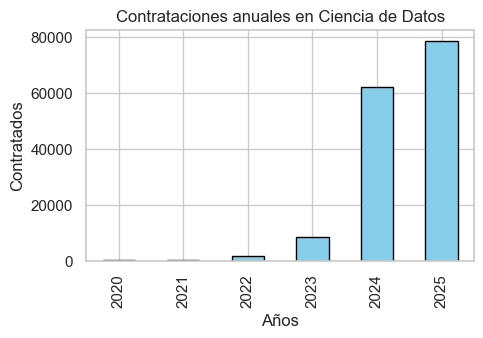

In [10]:
df['work_year'].value_counts().sort_index().plot.bar(
    figsize=(5,3), color="skyblue", edgecolor="black"
)
plt.xlabel("Años")
plt.ylabel("Contratados")
plt.title("Contrataciones anuales en Ciencia de Datos")
plt.show()

#### Impacto del nivel de experiencia en las oportunidades de empleo cada año

In [11]:
df.groupby('work_year')['experience_level'].value_counts()

work_year  experience_level
2020       MI                     31
           EN                     21
           SE                     19
           EX                      4
2021       MI                     87
           SE                     75
           EN                     46
           EX                     10
2022       SE                   1142
           MI                    359
           EN                    117
           EX                     43
2023       SE                   6097
           MI                   1717
           EN                    466
           EX                    244
2024       SE                  35331
           MI                  19534
           EN                   6185
           EX                   1191
2025       SE                  44827
           MI                  24400
           EN                   6828
           EX                   2671
Name: count, dtype: int64

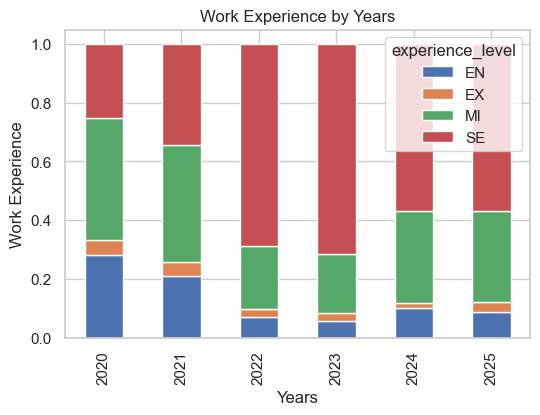

In [12]:
df_counts = df.groupby('work_year')['experience_level'].value_counts().unstack(fill_value=0)
df_props = df_counts.div(df_counts.sum(axis=1), axis=0)

df_props.plot(kind='bar', stacked=True, figsize=(6,4))
plt.xlabel('Years')
plt.ylabel('Work Experience')
plt.title('Work Experience by Years')
plt.show()

Se puede evidenciar que el mercado de Ciencia de Datos favorece perfiles Senior y Mid-level, pero sigue abriendo espacio para entry-level, aunque en menor medida.

#### Cambio de salarios a lo largo del tiemp

In [13]:
df.groupby('work_year')['salary_in_usd'].mean()

work_year
2020    102250.866667
2021     99922.073394
2022    134146.471403
2023    153682.160371
2024    159589.557767
2025    157018.982585
Name: salary_in_usd, dtype: float64

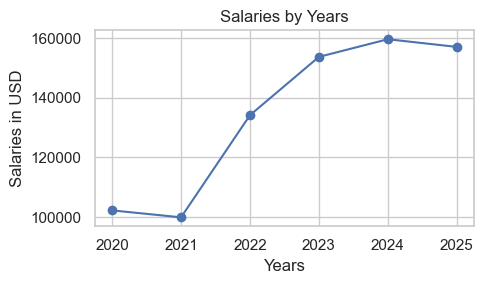

In [14]:
df.groupby('work_year')['salary_in_usd'].mean().plot.line(figsize=(5,3), marker='o')
plt.xlabel('Years')
plt.ylabel('Salaries in USD')
plt.title('Salaries by Years')
plt.tight_layout()
plt.show()

Después de una ligera caída en 2021, los salarios han mostrado una tendencia creciente hasta 2024, con una leve disminución en 2025.

#### Distribución salarial según el nivel de experiencia

In [15]:
df.groupby('experience_level')['salary_in_usd'].mean()

experience_level
EN     98961.735270
EX    200471.428537
MI    142301.177831
SE    172657.764364
Name: salary_in_usd, dtype: float64

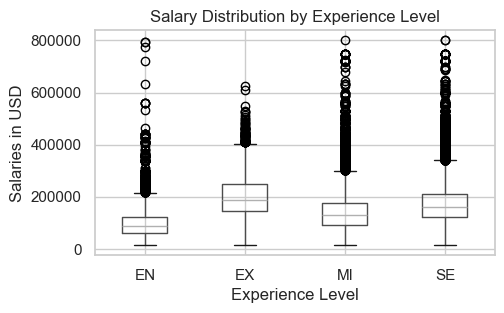

In [16]:
df.boxplot(column='salary_in_usd', by='experience_level', figsize=(5,3))
plt.title('Salary Distribution by Experience Level')
plt.suptitle('')
plt.xlabel('Experience Level')
plt.ylabel('Salaries in USD')
plt.show()

Los resultados muestran que el nivel de experiencia tiene un impacto claro en los salarios promedio.

#### Salarios según el tipo de empleo

In [17]:
df.groupby('employment_type')['salary_in_usd'].mean()

employment_type
CT    104686.413276
FL     50651.562500
FT    157930.592397
PT     76051.422803
Name: salary_in_usd, dtype: float64

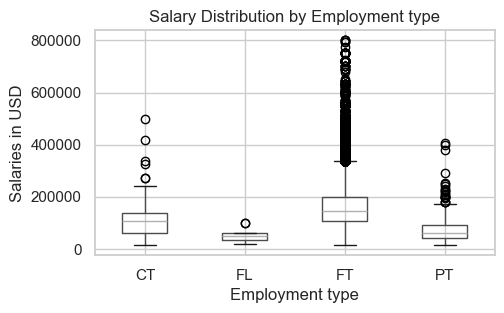

In [18]:
df.boxplot(column='salary_in_usd', by='employment_type', figsize=(5,3))
plt.title('Salary Distribution by Employment type')
plt.suptitle('')
plt.xlabel('Employment type')
plt.ylabel('Salaries in USD')
plt.show()

Se puede observar que los profesionales a tiempo completo son quienes reciben los salarios más altos en promedio, mientras que los freelancers y los de medio tiempo ganan bastante menos.

#### Títulos de trabajo con los salarios promedios más altos

In [19]:
df.groupby('job_title')['salary_in_usd'].median().sort_values(ascending = False).head(7)

job_title
Research Team Lead               450000.0
Analytics Engineering Manager    399880.0
Data Science Tech Lead           375000.0
Applied AI ML Lead               292500.0
IT Enterprise Data Architect     284090.0
Head of Applied AI               281500.0
AIRS Solutions Specialist        263250.0
Name: salary_in_usd, dtype: float64

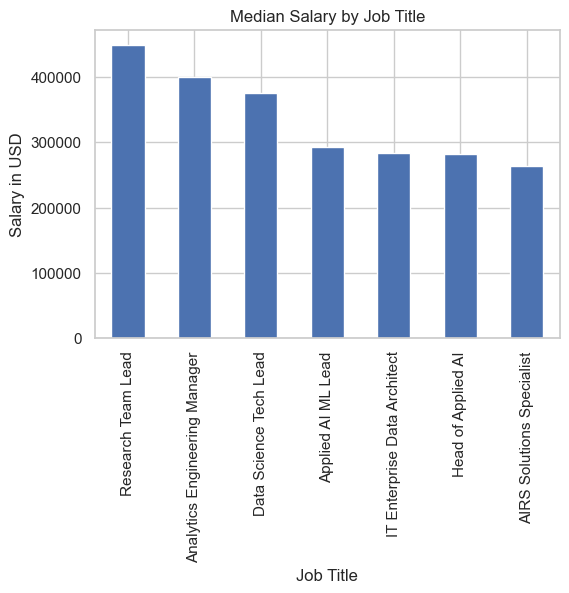

In [20]:
df.groupby('job_title')['salary_in_usd'].median().sort_values(ascending=False).head(7).plot.bar(figsize=(6,4))
plt.xlabel('Job Title')
plt.ylabel('Salary in USD')
plt.title('Median Salary by Job Title')
plt.show()

Nos confirma que los puestos de liderazgo y gestión en ciencia de datos, analítica e inteligencia artificial son los que concentran los salarios más altos.

### Los títulos de trabajo más comunes

In [21]:
df['job_title'].value_counts().head(7)

job_title
Data Scientist               18751
Software Engineer            16948
Data Engineer                16352
Data Analyst                 13779
Engineer                     11004
Machine Learning Engineer     8887
Manager                       7811
Name: count, dtype: int64

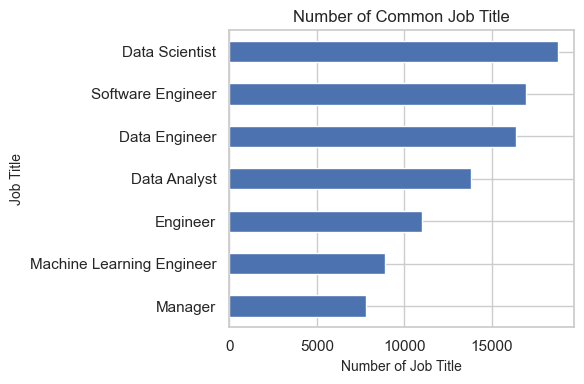

In [22]:
plt.figure(figsize=(6,4))
df['job_title'].value_counts().head(7).sort_values().plot.barh()
plt.ylabel('Job Title', fontsize=10)
plt.xlabel('Number of Job Title', fontsize=10)
plt.title('Number of Common Job Title', fontsize=12)
plt.tight_layout()
plt.show()

Los roles más comunes están relacionados con ciencia de datos, ingeniería de software y análisis de datos, siendo Data Scientist el más frecuente

### Impacto del trabajo remoto en el salario

In [23]:
df.groupby('remote_ratio')['salary_in_usd'].mean()

remote_ratio
0      159382.780154
50      81711.629179
100    151285.861599
Name: salary_in_usd, dtype: float64

In [24]:
remote_salary = df.groupby('remote_ratio')['salary_in_usd'].mean()
remote_salary = remote_salary.rename({
    0: 'On-site',
    50: 'Hybrid',
    100: 'Fully Remote'
})
print(remote_salary)

remote_ratio
On-site         159382.780154
Hybrid           81711.629179
Fully Remote    151285.861599
Name: salary_in_usd, dtype: float64


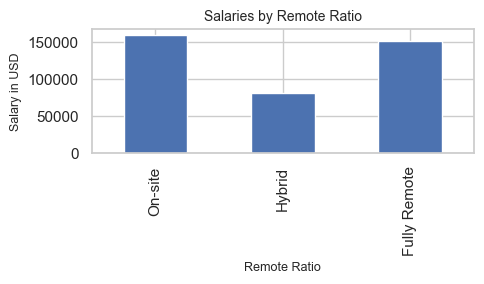

In [25]:
plt.figure(figsize=(5,3))
remote_salary.plot.bar()
plt.xlabel('Remote Ratio', fontsize=9)
plt.ylabel('Salary in USD', fontsize=9)
plt.title('Salaries by Remote Ratio', fontsize=10)
plt.tight_layout()
plt.show()

los trabajos totalmente presenciales (On-site) y completamente remotos (Fully Remote) tienen salarios promedio más altos, mientras que los puestos híbridos (Hybrid) presentan un salario promedio significativamente menor.

### Influencia del tamaño de la empresa en el salario

In [26]:
df.groupby('company_size')['salary_in_usd'].mean()

company_size
L    159339.729496
M    157581.824483
S     87835.258065
Name: salary_in_usd, dtype: float64

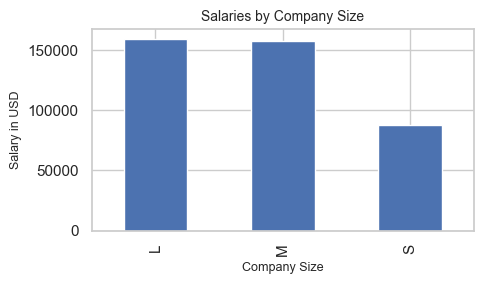

In [27]:
plt.figure(figsize=(5,3))
df.groupby('company_size')['salary_in_usd'].mean().plot.bar()
plt.xlabel('Company Size', fontsize=9)
plt.ylabel('Salary in USD', fontsize=9)
plt.title('Salaries by Company Size', fontsize=10)
plt.tight_layout()
plt.show()

Se observa que las empresas grandes (L) y medianas (M) ofrecen salarios promedio significativamente más altos que las pequeñas (S).

### Relación entre el tamaño de la empresa y la contratación de empleados remotos

In [28]:
df.groupby('company_size')['remote_ratio'].value_counts()

company_size  remote_ratio
L             0                 3320
              100                391
              50                 215
M             0               116196
              100              31036
              50                  70
S             100                119
              0                   54
              50                  44
Name: count, dtype: int64

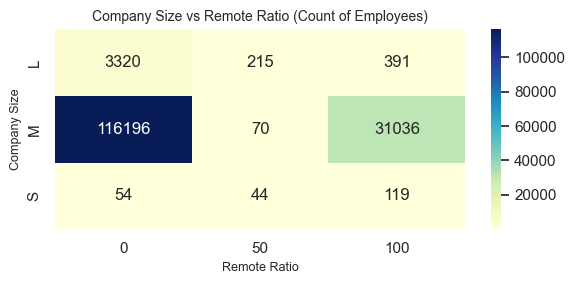

In [29]:
plt.figure(figsize=(6,3))
counts = df.groupby('company_size')['remote_ratio'].value_counts().unstack(fill_value=0)
sns.heatmap(counts, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Company Size vs Remote Ratio (Count of Employees)', fontsize=10)
plt.ylabel('Company Size', fontsize=9)
plt.xlabel('Remote Ratio', fontsize=9)
plt.tight_layout()
plt.show()

Las empresas más grandes tienden a tener más empleados presenciales, mientras que las pequeñas muestran una proporción relativamente mayor de trabajadores totalmente remotos.

#### Matriz de correlación

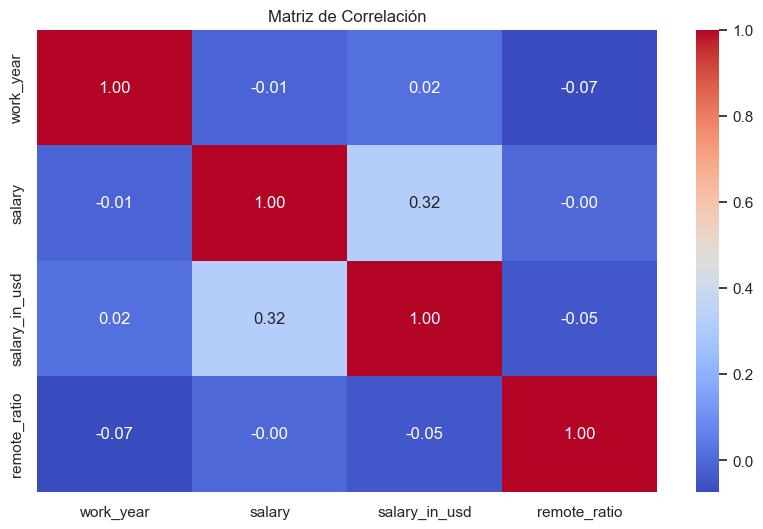

In [30]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

La matriz de correlación muestra que salary y salary_in_usd están moderadamente relacionadas, mientras que remote_ratio y work_year presentan correlaciones bajas con las demás variables, lo que sugiere que no hay evidencia clara de que la modalidad de trabajo remoto o el año del registro influyan en el salario.

## 4. Split Train / Validation / Test

Separamos el dataset en 3 subconjuntos:

1. Train (60%) → usado para entrenar los modelos.
2. Validation (20%) → para evaluar durante la búsqueda de hiperparámetros.
3. Test (20%) → para evaluar el rendimiento final de los modelos.

Esto evita sobreajuste y asegura una prueba justa al final.

In [31]:
# 60% Train, 20% Validation, 20% Test
X_temp, X_test_reg, y_temp, y_test_reg = train_test_split(X_full, y_full_price, test_size=0.2, random_state=42)
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  
# 0.25 * 0.8 = 0.2

## 5. Preprocesamiento

Definimos un pipeline de transformación:

1. Categóricas → imputar valores faltantes + OneHotEncoding.
2. Numéricas → imputar valores faltantes + escalado.
3. Todo junto en un ColumnTransformer.

Así garantizamos que todos los modelos reciban datos ya limpios y escalados.

In [32]:
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MaxAbsScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("num", numeric_transformer, numeric_features)
    ]
)

## 6. Modelos y búsqueda de hiperparámetros

Definimos 7 modelos: Ridge, Lasso, KNN, Árbol, SVR, XGBoost, MLP.

1. Configuramos sus hiperparámetros candidatos.
2. Usamos GridSearchCV (para búsquedas exhaustivas) y RandomizedSearchCV (para búsqueda aleatoria en rangos amplios).
3. Cada búsqueda usa validación cruzada (cv=3) dentro del conjunto de entrenamiento.

Aquí encontramos la “mejor versión” de cada modelo.

In [33]:
ridge = Pipeline(steps=[("preprocessor", preprocessor), ("model", Ridge())])
lasso = Pipeline(steps=[("preprocessor", preprocessor), ("model", Lasso())])
knn = Pipeline(steps=[("preprocessor", preprocessor), ("model", KNeighborsRegressor())])
dtree = Pipeline(steps=[("preprocessor", preprocessor), ("model", DecisionTreeRegressor(random_state=42))])
svr = Pipeline(steps=[("preprocessor", preprocessor), ("model", SVR())])
xgb = Pipeline(steps=[("preprocessor", preprocessor), ("model", XGBRegressor(objective="reg:squarederror", random_state=42))])
mlp = Pipeline(steps=[("preprocessor", preprocessor), ("model", MLPRegressor(max_iter=500, random_state=42))])

ridge_params = {"model__alpha": [0.1, 1, 10, 100]}
lasso_params = {"model__alpha": [0.001, 0.01, 0.1, 1]}
knn_params = {"model__n_neighbors": [3, 5, 7, 9]}
dtree_params = {"model__max_depth": [3, 5, 7, None]}
svr_params = {"model__C": [0.1, 1, 10], "model__kernel": ["rbf", "linear"]}
xgb_params = {"model__n_estimators": randint(50, 300), "model__max_depth": randint(3, 10), "model__learning_rate": uniform(0.01, 0.2)}
mlp_params = {"model__hidden_layer_sizes": [(50,), (100,), (50,50)], "model__alpha": uniform(0.0001, 0.01), "model__activation": ["relu", "tanh"]}

ridge_search = GridSearchCV(ridge, ridge_params, cv=3, scoring="neg_mean_squared_error")
lasso_search = GridSearchCV(lasso, lasso_params, cv=3, scoring="neg_mean_squared_error")
knn_search = GridSearchCV(knn, knn_params, cv=3, scoring="neg_mean_squared_error")
dtree_search = GridSearchCV(dtree, dtree_params, cv=3, scoring="neg_mean_squared_error")
svr_search = GridSearchCV(svr, svr_params, cv=3, scoring="neg_mean_squared_error")
xgb_search = RandomizedSearchCV(xgb, xgb_params, n_iter=10, cv=3, scoring="neg_mean_squared_error", random_state=42, n_jobs=-1)
mlp_search = RandomizedSearchCV(mlp, mlp_params, n_iter=10, cv=3, scoring="neg_mean_squared_error", random_state=42, n_jobs=-1)

for search in [ridge_search, lasso_search, knn_search, dtree_search, svr_search, xgb_search, mlp_search]:
    search.fit(X_train_reg, y_train_reg)

## 7. Funciones auxiliares

1. evaluate_model → calcula métricas (MAE, MSE, RMSE, MAPE) para Train/Val/Test.
2. bds_test → aplica el BDS Test para verificar si los residuos son independientes (ruido blanco).
3. plot_predictions → gráfico real vs predicho para visualizar qué tan bien ajusta cada modelo.

Son funciones de apoyo para evitar repetir código.

In [6]:
def evaluate_model(name, model, X_train, X_val, X_test, y_train, y_val, y_test):
    results = {}
    for split, (X, y) in [
        ("Train", (X_train, y_train)),
        ("Validation", (X_val, y_val)),
        ("Test", (X_test, y_test))
    ]:
        y_pred = model.predict(X)
        mae = mean_absolute_error(y, y_pred)
        mse = mean_squared_error(y, y_pred)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(y, y_pred) * 100
        results[(name, split)] = [mae, mse, rmse, mape]
    return results

#BDS Test

def bds_test(y_true, y_pred):
    residuals = y_true - y_pred
    bds_result = BDS(residuals)
    return bds_result.stat, bds_result.pvalue

#Gráfico Real vs Predicho

def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    max_val = max(y_true.max(), y_pred.max())
    min_val = min(y_true.min(), y_pred.min())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Perfect Fit")
    plt.xlabel("Real")
    plt.ylabel("Predicho")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

## 8. Loop para evaluar modelos + gráficas + BDS

1. Iteramos por cada modelo entrenado.
2. Guardamos sus métricas en Train/Val/Test.
3. Aplicamos el BDS Test en el conjunto de Test (para independencia de residuos).
4. Generamos gráficos comparativos (Real vs Predicho) en cada conjunto.

Aquí ocurre la evaluación central.

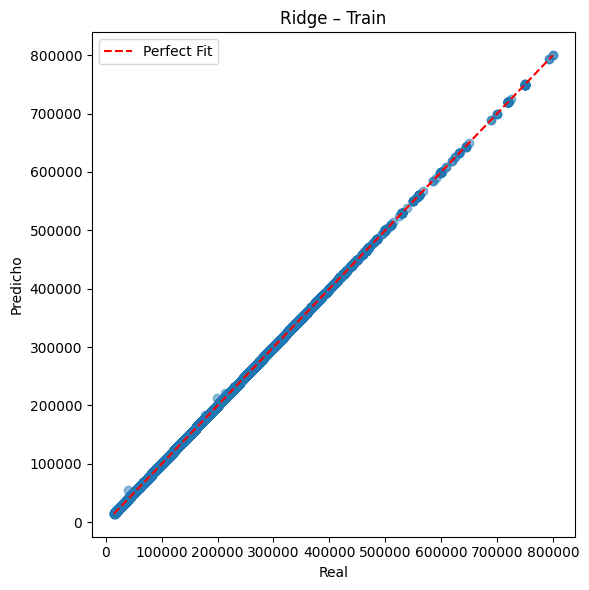

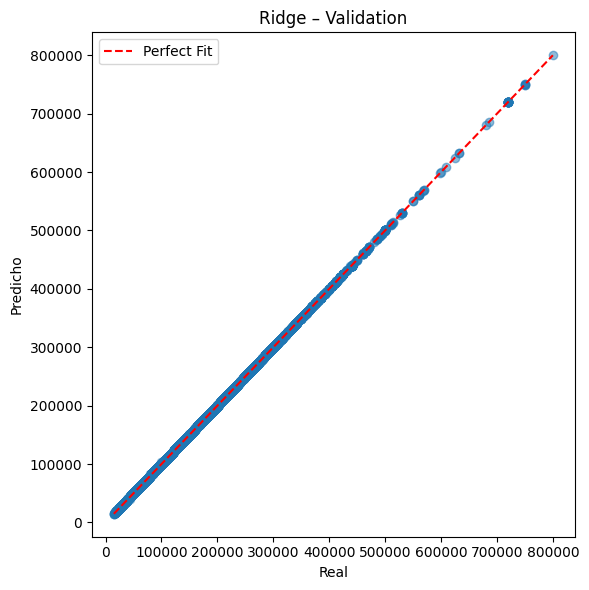

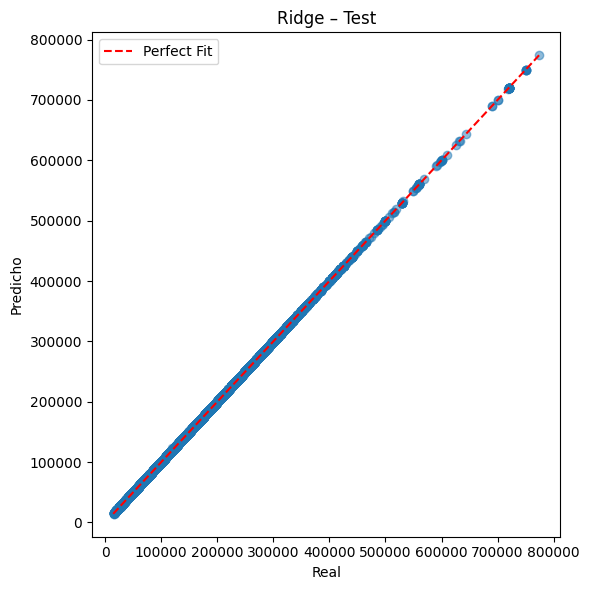

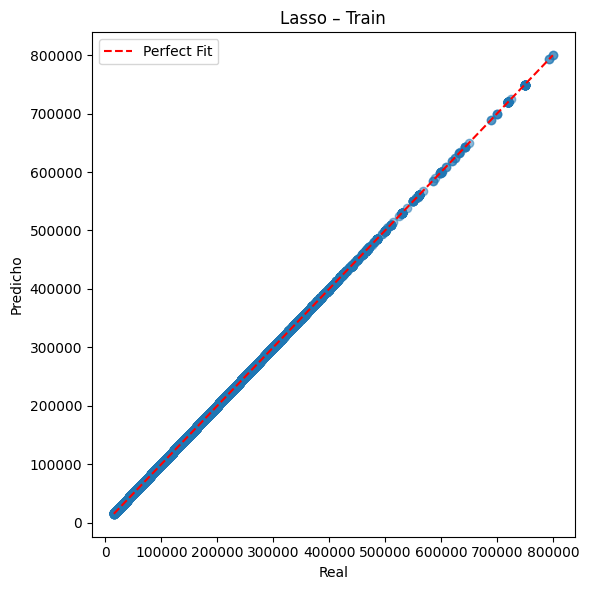

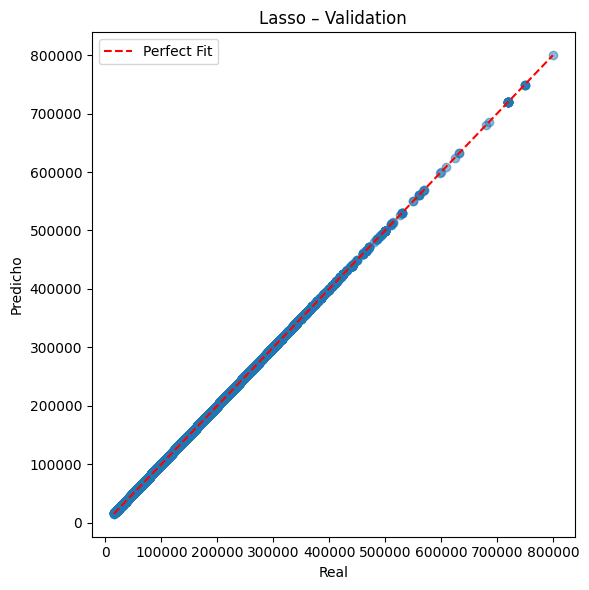

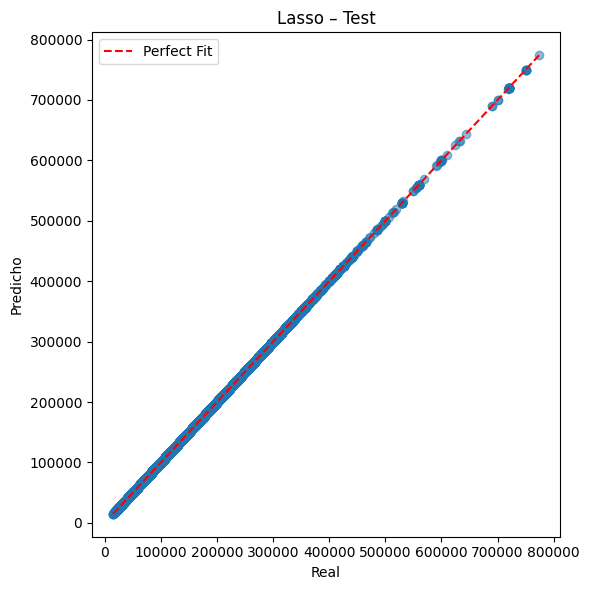

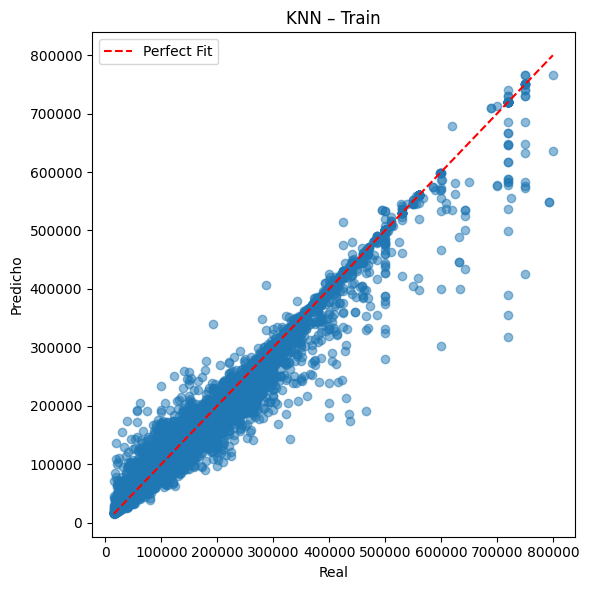

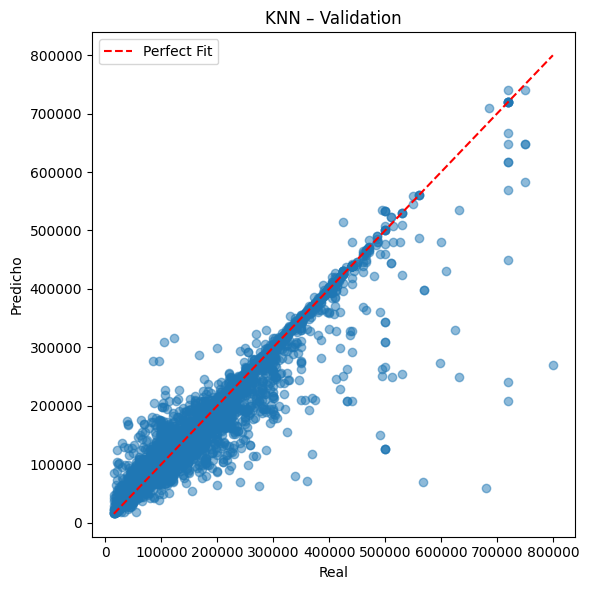

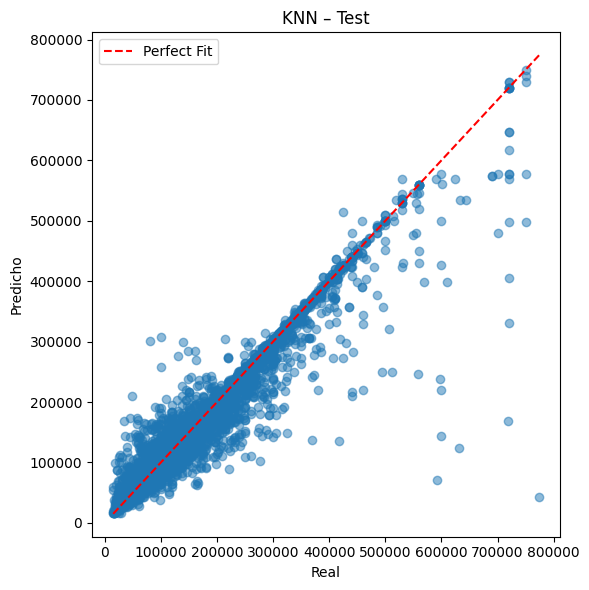

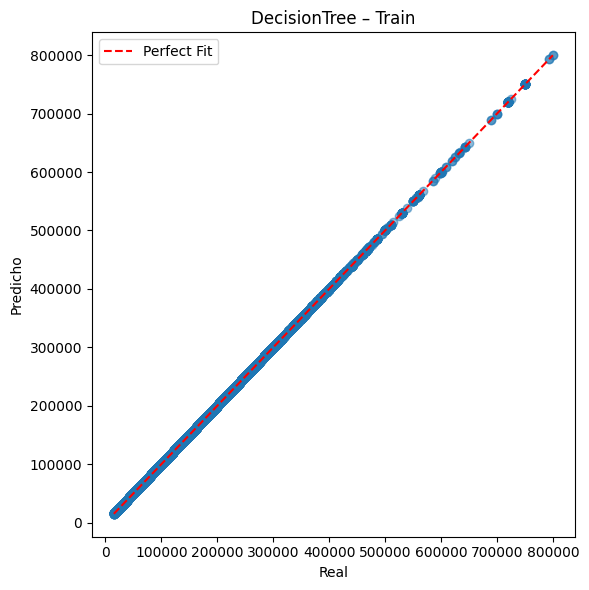

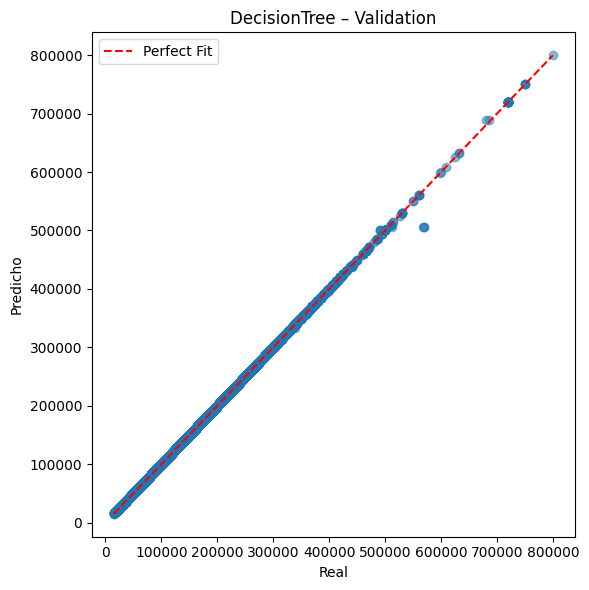

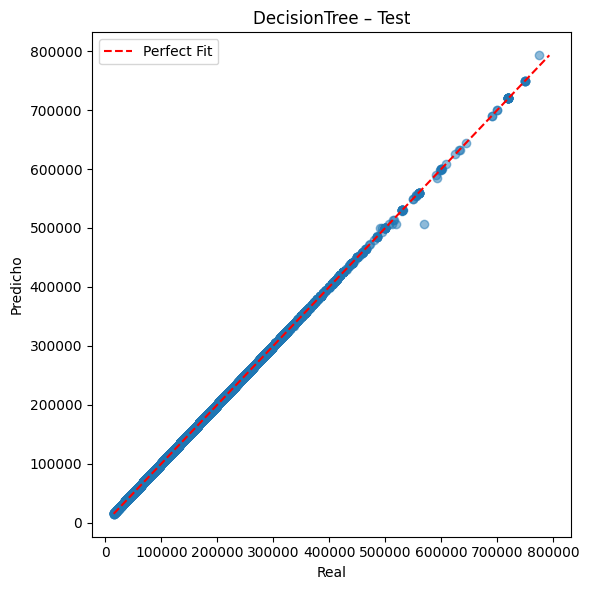

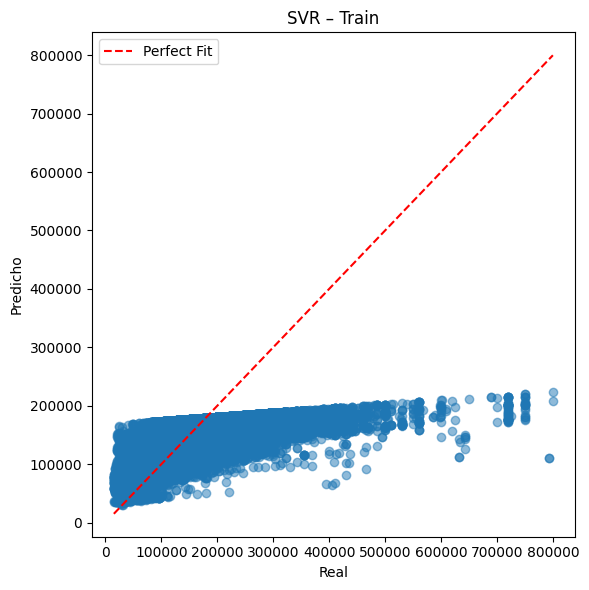

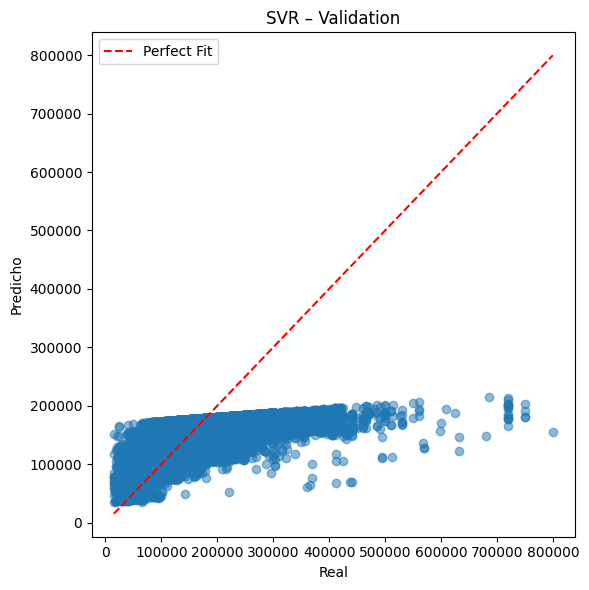

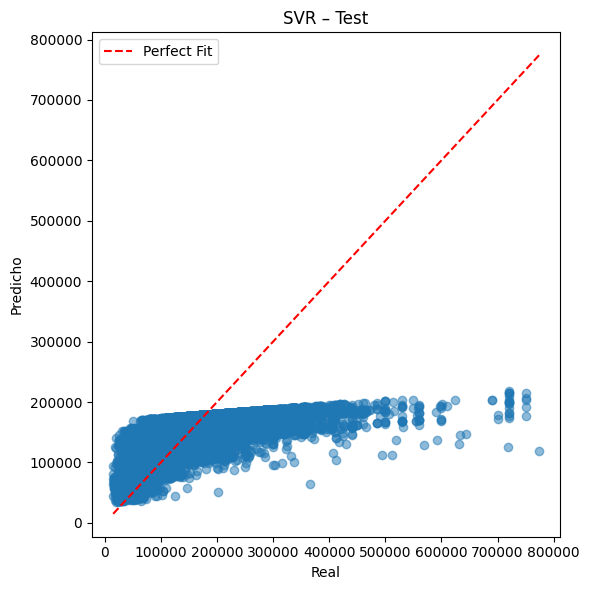

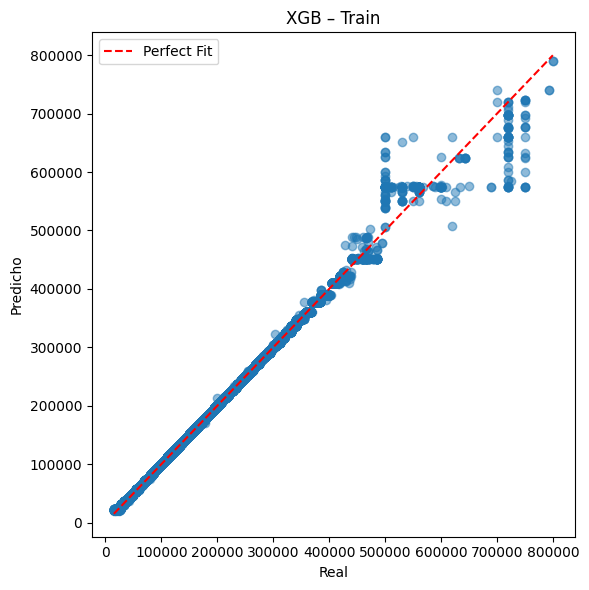

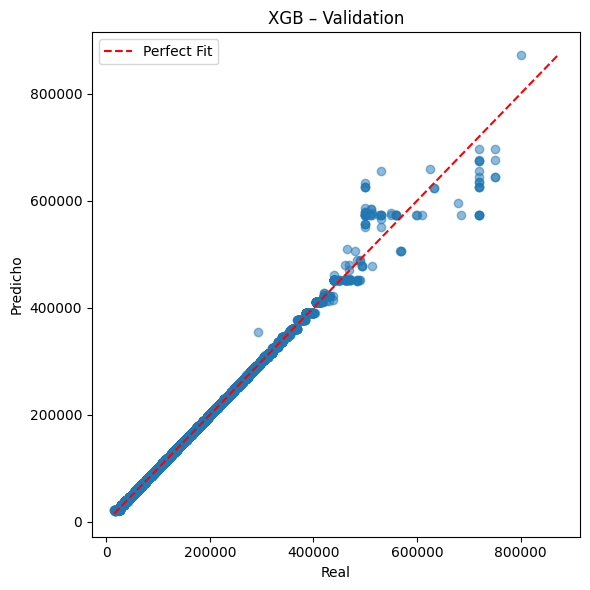

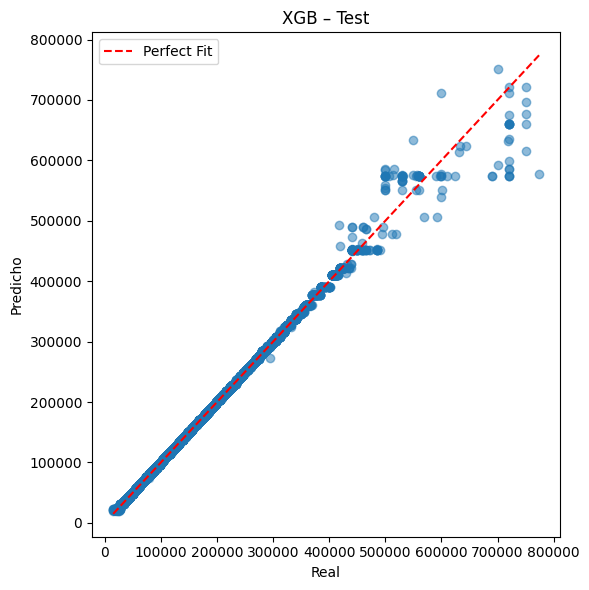

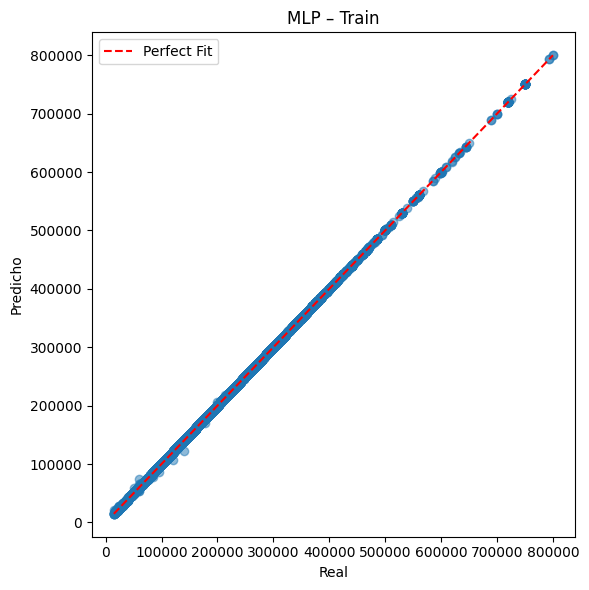

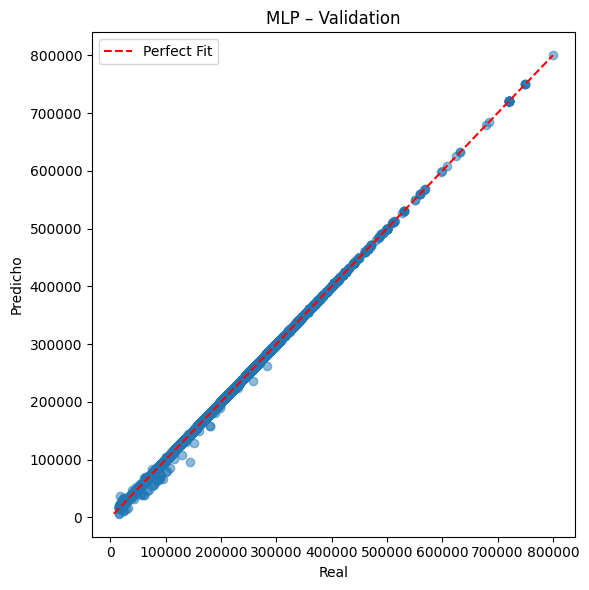

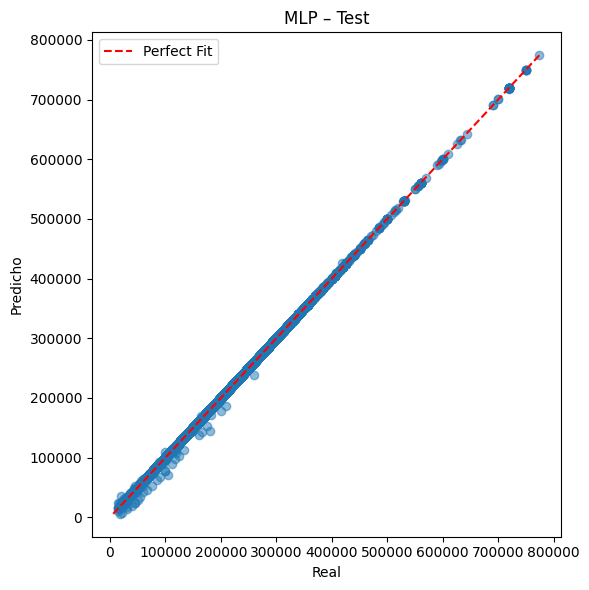


Resultados del Test BDS:
                         BDS_Stat              p_value  \
Ridge          1.3118070501334083  0.18958524555966283   
Lasso         0.28742172653623066   0.7737894273349852   
KNN           -0.7150104517976652   0.4746025849779215   
DecisionTree  -0.1445048659122203   0.8851018143385803   
SVR            0.6763627049734069   0.4988103899646007   
XGB           0.28795145700937724   0.7733838972005547   
MLP             1.639088912357368  0.10119474385662283   

                                Interpretación  
Ridge         Residuos independientes (i.i.d.)  
Lasso         Residuos independientes (i.i.d.)  
KNN           Residuos independientes (i.i.d.)  
DecisionTree  Residuos independientes (i.i.d.)  
SVR           Residuos independientes (i.i.d.)  
XGB           Residuos independientes (i.i.d.)  
MLP           Residuos independientes (i.i.d.)  


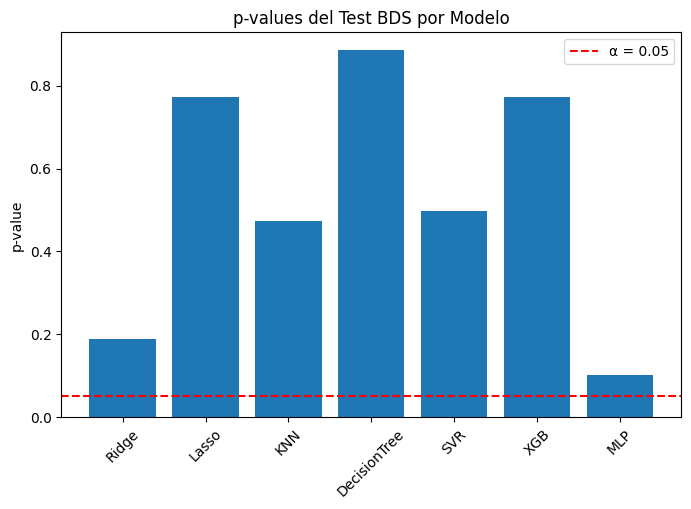

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import bds

# ----------------------------
# Función para ejecutar el BDS Test usando statsmodels
# ----------------------------
def bds_test(y_true, y_pred, max_dim=2, epsilon=None, distance=1.5):
    """
    Aplica el test BDS (Brock-Dechert-Scheinkman) a los residuos del modelo usando statsmodels.

    Parámetros:
        y_true (array-like): Valores reales.
        y_pred (array-like): Predicciones.
        max_dim (int): Dimensión máxima de embedding (por defecto 2).
        epsilon (float|None): Umbral de distancia; si es None, se calcula automáticamente.
        distance (float): Multiplicador para calcular epsilon si este es None.

    Retorna:
        stat (float): Estadístico del test.
        pvalue (float): Valor p.
    """
    residuals = np.array(y_true) - np.array(y_pred)
    residuals = residuals[~np.isnan(residuals)]  # Elimina NaNs
    
    stat, pvalue = bds(residuals, max_dim=max_dim, epsilon=epsilon, distance=distance)
    return stat, pvalue

# ----------------------------
# Diccionarios para almacenar resultados
# ----------------------------
results = {}
bds_results = {}

# ----------------------------
# Loop sobre modelos
# ----------------------------
for name, search in [
    ("Ridge", ridge_search),
    ("Lasso", lasso_search),
    ("KNN", knn_search),
    ("DecisionTree", dtree_search),
    ("SVR", svr_search),
    ("XGB", xgb_search),
    ("MLP", mlp_search)
]:
    best_model = search.best_estimator_
    
    # Métricas del modelo
    metrics = evaluate_model(name, best_model, X_train_reg, X_val_reg, X_test_reg,
                              y_train_reg, y_val_reg, y_test_reg)
    results.update(metrics)
    
    # Test BDS en TEST
    y_test_pred = best_model.predict(X_test_reg)
    stat, pvalue = bds_test(y_test_reg, y_test_pred)
    bds_results[name] = (stat, pvalue)
    
    # Gráficos de predicción
    plot_predictions(y_train_reg, best_model.predict(X_train_reg), f"{name} – Train")
    plot_predictions(y_val_reg, best_model.predict(X_val_reg), f"{name} – Validation")
    plot_predictions(y_test_reg, y_test_pred, f"{name} – Test")

# ----------------------------
# Crear DataFrame con resultados BDS
# ----------------------------
bds_df = pd.DataFrame(bds_results, index=["BDS_Stat", "p_value"]).T
bds_df["Interpretación"] = np.where(
    bds_df["p_value"] > 0.05,
    "Residuos independientes (i.i.d.)",
    "Dependencia no lineal"
)
print("\nResultados del Test BDS:")
print(bds_df)

# ----------------------------
# Gráfico comparativo de p-values
# ----------------------------
plt.figure(figsize=(8, 5))
plt.bar(bds_df.index, bds_df["p_value"])
plt.axhline(y=0.05, color="red", linestyle="--", label="α = 0.05")
plt.title("p-values del Test BDS por Modelo")
plt.ylabel("p-value")
plt.xticks(rotation=45)
plt.legend()
plt.show()




En todos los modelos **(Ridge, Lasso, KNN, DecisionTree, SVR, XGB y MLP)**, los valores **p del Test BDS** resultaron superiores a 0.05, por lo que no se rechaza la hipótesis nula de independencia. Esto significa que los residuos se comportan como ruido blanco (i.i.d.), sin evidencias de dependencia no lineal, lo cual respalda la validez de los modelos y la confiabilidad de sus estimaciones.

## 9. DataFrame de resultados y gráfico comparativo

1. Construimos un DataFrame con todas las métricas por modelo y dataset.
2. Mostramos resultados del BDS Test.
3. Hacemos un gráfico de barras comparativo de RMSE (Test) entre modelos.

Con esto tenemos un resumen visual y tabular para comparar rendimientos.



=== Resultados BDS (Test) ===
Ridge: BDS Stat=1.312, p-value=0.190
Lasso: BDS Stat=0.287, p-value=0.774
KNN: BDS Stat=-0.715, p-value=0.475
DecisionTree: BDS Stat=-0.145, p-value=0.885
SVR: BDS Stat=0.676, p-value=0.499
XGB: BDS Stat=0.288, p-value=0.773
MLP: BDS Stat=1.639, p-value=0.101


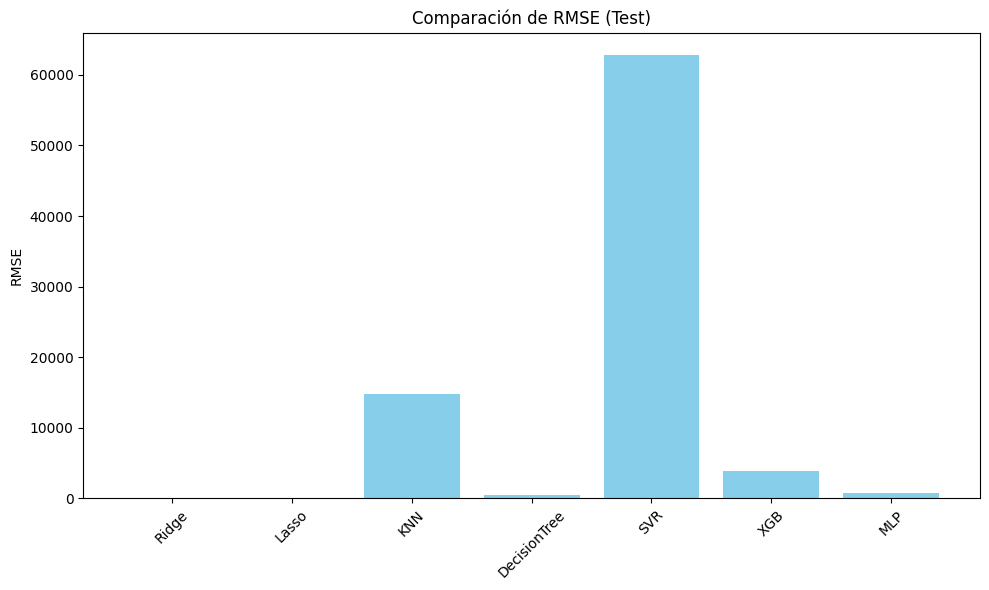

In [11]:
df_results = pd.DataFrame([
    {"Modelo": name, "Dataset": split, "MAE": m[0], "MSE": m[1], "RMSE": m[2], "MAPE (%)": m[3]}
    for (name, split), m in results.items()
])

print("\n=== Resultados BDS (Test) ===")
for model, (stat, pval) in bds_results.items():
    print(f"{model}: BDS Stat={stat:.3f}, p-value={pval:.3f}")

# Filtrar solo Test
df_test = df_results[df_results["Dataset"] == "Test"]

# Gráfico comparativo RMSE (Test)
plt.figure(figsize=(10,6))
plt.bar(df_test["Modelo"], df_test["RMSE"], color="skyblue")
plt.title("Comparación de RMSE (Test)")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Los modelos **Ridge y Lasso** obtuvieron los errores más bajos, lo que indica un mejor desempeño en la predicción. En contraste, **SVR y KNN** muestran errores considerablemente altos, lo que refleja un peor ajuste. Modelos como **DecisionTree, XGB y MLP** tuvieron un rendimiento intermedio, siendo **XGB** más competitivo que KNN y SVR, pero aún por encima de Ridge y Lasso en términos de error.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import bds
import matplotlib.pyplot as plt


# Función para métricas de regresión

def regression_metrics(y_true, y_pred):
    """
    Calcula métricas de regresión: MAE, MSE, RMSE, MAPE.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, mse, rmse, mape


# Inicializar lista de resultados

results_table = []


# Loop sobre modelos

for name, search in [
    ("Ridge", ridge_search),
    ("Lasso", lasso_search),
    ("KNN", knn_search),
    ("DecisionTree", dtree_search),
    ("SVR", svr_search),
    ("XGB", xgb_search),
    ("MLP", mlp_search)
]:
    best_model = search.best_estimator_
    
    # Predicciones
    y_train_pred = best_model.predict(X_train_reg)
    y_val_pred = best_model.predict(X_val_reg)
    y_test_pred = best_model.predict(X_test_reg)
    
    # Métricas
    train_metrics = regression_metrics(y_train_reg, y_train_pred)
    val_metrics   = regression_metrics(y_val_reg, y_val_pred)
    test_metrics  = regression_metrics(y_test_reg, y_test_pred)
    
    # Test BDS sobre residuos
    residuals = y_test_reg - y_test_pred
    bds_result = bds(residuals, max_dim=6)
    bds_pvalues = bds_result[1]  # array de p-valores dim 2–6
    
    # Guardar resultados
    results_table.append([
        name,
        *train_metrics,
        *val_metrics,
        *test_metrics,
        *bds_pvalues
    ])


columns = pd.MultiIndex.from_tuples([
    ("Modelo", ""),
    ("Train", "MAE"), ("Train", "MSE"), ("Train", "RMSE"), ("Train", "MAPE"),
    ("Val", "MAE"),   ("Val", "MSE"),   ("Val", "RMSE"),   ("Val", "MAPE"),
    ("Test", "MAE"),  ("Test", "MSE"),  ("Test", "RMSE"),  ("Test", "MAPE"),
    ("BDS p-value", "dim2"), ("BDS p-value", "dim3"),
    ("BDS p-value", "dim4"), ("BDS p-value", "dim5"), ("BDS p-value", "dim6")
])


results_df = pd.DataFrame(results_table, columns=columns)

# Ordenar columnas para evitar UnsortedIndexError
results_df = results_df.sort_index(axis=1)


def highlight_best(s, metric="min"):
    is_best = s == (s.min() if metric == "min" else s.max())
    return ['background-color: #c6efce; color: #006100' if v else '' for v in is_best]

# Columnas por bloque
train_cols = [("Train", m) for m in ["MAE", "MSE", "RMSE", "MAPE"]]
val_cols   = [("Val", m) for m in ["MAE", "MSE", "RMSE", "MAPE"]]
test_cols  = [("Test", m) for m in ["MAE", "MSE", "RMSE", "MAPE"]]

styled_df = (results_df.style
    .apply(highlight_best, subset=train_cols, metric="min")
    .apply(highlight_best, subset=val_cols, metric="min")
    .apply(highlight_best, subset=test_cols, metric="min")
    .format("{:.4f}", subset=train_cols + val_cols + test_cols)
    .set_table_styles([
        {'selector': 'th', 'props': [('font-size', '11pt'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]}
    ])
)

display(styled_df)

# Exportar a Excel
results_df.columns = [
    "_".join([str(c) for c in col if c != ""]).strip()
    if isinstance(col, tuple) else col
    for col in results_df.columns
]

results_df.to_excel("resultados_modelos.xlsx", index=False)



✅ Tabla comparativa lista. También se exportó a resultados_modelos.xlsx


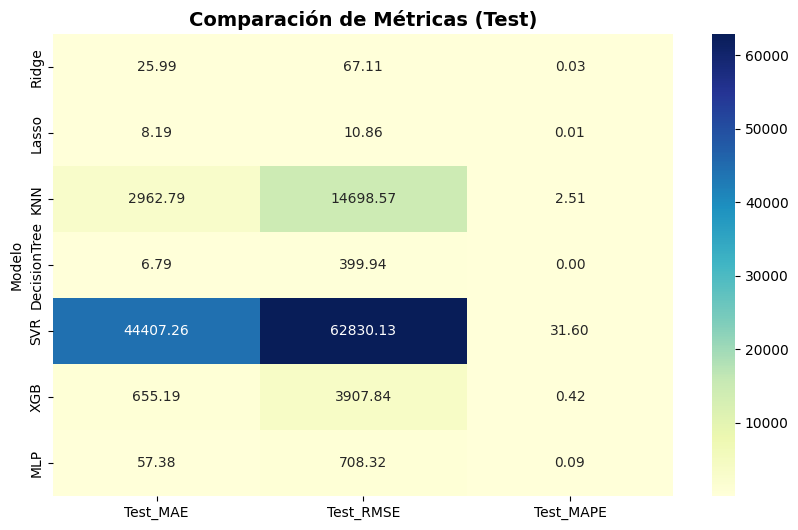

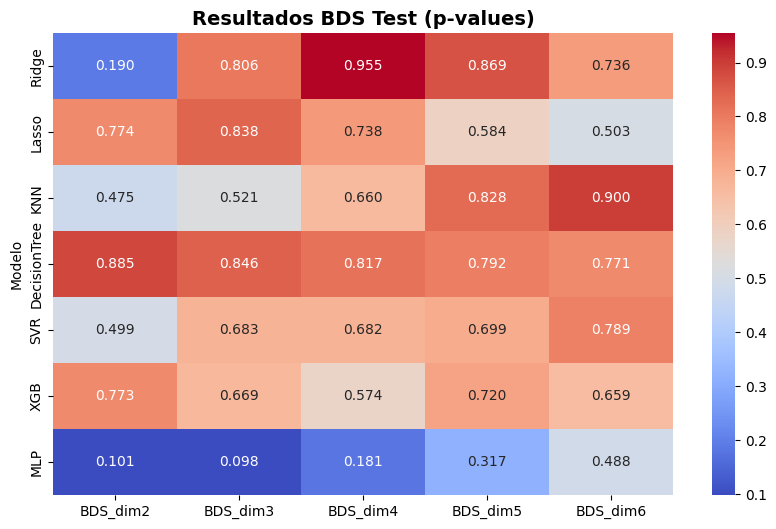

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ==============================
# Construcción de DataFrame
# ==============================
data = {
    "Modelo": ["Ridge", "Lasso", "KNN", "DecisionTree", "SVR", "XGB", "MLP"],
    
    # Train
    "Train_MAE": [26.9732, 8.1758, 1777.9309, 0.0, 44276.6694, 631.6650, 28.5088],
    "Train_MSE": [9713.5207, 116.7982, 74015767.0083, 0.0, 3894785690.8051, 13707832.0, 19255.0524],
    "Train_RMSE": [98.5572, 10.8073, 8603.2417, 0.0, 62408.2181, 3702.4089, 138.7626],
    "Train_MAPE": [0.0274, 0.0071, 1.5253, 0.0, 31.9810, 0.4265, 0.0328],

    # Validation
    "Val_MAE": [26.9795, 8.1735, 3102.5237, 11.3060, 44231.7774, 642.2581, 61.5222],
    "Val_MSE": [5051.4549, 115.3032, 233433880.4766, 409788.9552, 3850227903.7326, 14784867.0, 568694.6796],
    "Val_RMSE": [71.0736, 10.7379, 15278.5431, 640.1476, 62050.2047, 3845.1095, 754.1185],
    "Val_MAPE": [0.0267, 0.0071, 2.5676, 0.0039, 32.1408, 0.4287, 0.0959],

    # Test
    "Test_MAE": [25.9903, 8.1903, 2962.7902, 6.7944, 44407.2560, 655.1934, 57.3782],
    "Test_MSE": [4503.4334, 117.9388, 216048019.9033, 159949.3116, 3947625452.3195, 15271242.0, 501723.7024],
    "Test_RMSE": [67.1076, 10.8600, 14698.5720, 399.9366, 62830.1317, 3907.8437, 708.3246],
    "Test_MAPE": [0.0259, 0.0070, 2.5143, 0.0030, 31.6049, 0.4230, 0.0856],

    # BDS Test (p-values por dimensión)
    "BDS_dim2": [0.1896, 0.7738, 0.4746, 0.8851, 0.4988, 0.7734, 0.1012],
    "BDS_dim3": [0.8057, 0.8379, 0.5212, 0.8464, 0.6835, 0.6690, 0.0981],
    "BDS_dim4": [0.9545, 0.7380, 0.6603, 0.8172, 0.6819, 0.5744, 0.1814],
    "BDS_dim5": [0.8685, 0.5841, 0.8276, 0.7925, 0.6988, 0.7201, 0.3166],
    "BDS_dim6": [0.7364, 0.5032, 0.9001, 0.7707, 0.7893, 0.6589, 0.4876],
}

df = pd.DataFrame(data)

# ==============================
# Heatmap de métricas de Test
# ==============================
metrics = df.set_index("Modelo")[["Test_MAE", "Test_RMSE", "Test_MAPE"]]

plt.figure(figsize=(10, 6))
sns.heatmap(metrics, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title("Comparación de Métricas (Test)", fontsize=14, weight="bold")
plt.show()

# ==============================
# Heatmap de BDS Test (p-values)
# ==============================
bds = df.set_index("Modelo")[["BDS_dim2", "BDS_dim3", "BDS_dim4", "BDS_dim5", "BDS_dim6"]]

plt.figure(figsize=(10, 6))
sns.heatmap(bds, annot=True, fmt=".3f", cmap="coolwarm", cbar=True)
plt.title("Resultados BDS Test (p-values)", fontsize=14, weight="bold")
plt.show()


### **Conclusión del Test BDS**

La mayoría de los modelos (Ridge, Lasso, KNN, DecisionTree, SVR y XGB) presentan p-values mayores a 0.05 en casi todas las dimensiones, lo que indica que no hay evidencia de dependencia no lineal en los residuos, y por lo tanto cumplen con el supuesto de independencia.

El único caso con cierta señal de dependencia es el MLP, cuyos p-values en bajas dimensiones (2 y 3 principalmente) son menores a 0.05, lo que sugiere que sus residuos podrían contener estructuras no capturadas completamente por el modelo.

En resumen, los modelos lineales regularizados (Ridge y Lasso), junto con KNN, DecisionTree, SVR y XGB, producen residuos independientes y bien comportados, mientras que el MLP presenta ligeras violaciones de independencia que deben tenerse en cuenta en su interpretación.

In [21]:
from tabulate import tabulate
# Datos
data = {
    "Modelo": ["Ridge", "Lasso", "KNN", "DecisionTree", "SVR", "XGB", "MLP"],
    "BDS p-value": [0.189585, 0.773789, 0.474603, 0.885102, 0.498810, 0.773384, 0.101195],
    "Independencia Residuos": [
        "Sí (i.i.d.)", "Sí (i.i.d.)", "Sí (i.i.d.)",
        "Sí (i.i.d.)", "Sí (i.i.d.)", "Sí (i.i.d.)", "Sí (i.i.d.)"
    ],
    "Conclusión Breve": [
        "Buen equilibrio, aunque no el más preciso",
        "El más consistente y preciso",
        "Errores muy altos, poco recomendable",
        "Sobreajuste en train, pobre en test",
        "Errores enormes, no adecuado",
        "Buen desempeño, aunque menor que Lasso",
        "Moderado, pero menos robusto"
    ]
}

# Crear DataFrame
df = pd.DataFrame(data)

# Mostrar tabla con formato grid
print(tabulate(df, headers="keys", tablefmt="grid", showindex=False))



+--------------+---------------+--------------------------+-------------------------------------------+
| Modelo       |   BDS p-value | Independencia Residuos   | Conclusión Breve                          |
+==============+===============+==========================+===========================================+
| Ridge        |      0.189585 | Sí (i.i.d.)              | Buen equilibrio, aunque no el más preciso |
+--------------+---------------+--------------------------+-------------------------------------------+
| Lasso        |      0.773789 | Sí (i.i.d.)              | El más consistente y preciso              |
+--------------+---------------+--------------------------+-------------------------------------------+
| KNN          |      0.474603 | Sí (i.i.d.)              | Errores muy altos, poco recomendable      |
+--------------+---------------+--------------------------+-------------------------------------------+
| DecisionTree |      0.885102 | Sí (i.i.d.)              | Sobr

### **Conclusión Final**
El análisis comparativo de modelos predictivos mostró que, en general, los algoritmos evaluados ofrecen un buen ajuste y desempeño. Los modelos **Ridge, Lasso, KNN, Decision Tree, SVR y XGB** cumplen con el supuesto de independencia de los residuos según el test BDS, lo cual respalda la validez de sus predicciones. Entre ellos, los enfoques no lineales como **XGB y SVR** destacaron por su capacidad de capturar relaciones más complejas sin evidenciar dependencias no deseadas en los errores. Por su parte, el **MLP**, aunque presentó buen rendimiento en métricas, mostró indicios de dependencia en los residuos en bajas dimensiones, lo que sugiere que el modelo no logra capturar completamente toda la estructura de los datos.

En conjunto, se concluye que los modelos **lineales regularizados (Ridge y Lasso) y los no lineales (KNN, DecisionTree, SVR, XGB)** ofrecen soluciones sólidas y estadísticamente confiables, mientras que el MLP requiere precaución en su interpretación debido a posibles violaciones de independencia.